In [22]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='5'
import timm
import copy
import torch
import numpy
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

In [4]:
def create_convnext():
    model = timm.create_model('convnext_large_in22k', pretrained=True)
    model.head.fc = torch.nn.Linear(in_features=model.head.fc.in_features, out_features=3)
    return model
def create_swin():
    model = timm.create_model('swin_base_patch4_window7_224_in22k', pretrained = True)
    model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=3)
    return model

In [5]:
train_data = torchvision.datasets.ImageFolder('data/train')
valid_data = torchvision.datasets.ImageFolder('data/valid')
test_data = torchvision.datasets.ImageFolder('data/test')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=80, shuffle=True, num_workers=32)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=False, num_workers=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=32)
train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                torchvision.transforms.RandomRotation(degrees=(-45, 45)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=(0.693, 0.565, 0.52),
                                                            std=(0.101, 0.121, 0.135))])
normal_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=(0.693, 0.565, 0.52),
                                                            std=(0.101, 0.121, 0.135))])

train_loader.dataset.transform = train_transform
valid_loader.dataset.transform = normal_transform
test_loader.dataset.transform = normal_transform

In [6]:
def mixup(x, label):    
    mixupfactor, bs = float(torch.rand(1)), x.size()[0]
    index = torch.randperm(bs).to(device)
    mixing = mixupfactor * x + (1 - mixupfactor) * x[index, :]
    return mixing, label, label[index], mixupfactor

def mixuplossfunc(criterion, out, label1, label2, mixupfactor):
    return mixupfactor * criterion(out, label1) + (1 - mixupfactor) * criterion(out, label2)

In [7]:
def train(model_name, model, criterion, optimizer, epochs, mixup_=False, scheduler=None):
    model.to(device)
    validlossmin = numpy.inf
    for epoch in range(1, epochs+1):  
        trainloss,validloss = 0., 0.
        model.train()                                          
        for batchidx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            if mixup_:
                data, label1, label2, mixupfactor = mixup(data, target)
                data, label1, label2 = map(torch.autograd.Variable, (data, label1, label2))
                output = model(data)
                loss = mixuplossfunc(criterion, output, label1, label2, mixupfactor)
            else:
                output = model(data)
                loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            trainloss += ((1 / (batchidx + 1)) * (loss.data.item() - trainloss))  

        model.eval()
        with torch.no_grad():
            dataset_size, running_corrects = 0, 0
            for batchidx, (data, target) in enumerate(valid_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                validloss += ((1 / (batchidx + 1)) * (loss.data.item() - validloss))
                _, preds = torch.max(output, 1)
                running_corrects += torch.sum(preds == target.data)
                dataset_size += len(data)
            accuracy = torch.true_divide(running_corrects, dataset_size)
            print(f'Epoch {epoch} \nTrain loss {trainloss:.4f} \nValid loss {validloss:.4f} \nAccuracy {accuracy:.3f}')
            if validloss < validlossmin:
                validlossmin = validloss
                print('Saving model')
                torch.save(model.state_dict(), model_name+'.pt')

    model.load_state_dict(torch.load(model_name+'.pt'))
    return model



In [8]:
def test(model, return_metric=False):
    model = model.to(device)
    model.eval()
    testloss = 0.0
    
    for batchidx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        testloss += ((1 / (batchidx + 1)) * (loss.data.item() - testloss))
        pred = output.data
        if batchidx:
            preds = torch.cat((preds,pred))
            targs = torch.cat((targs,target.data.view(pred.shape[:-1])))
        else:
            preds=pred
            targs=target.data.view(pred.shape[:-1])
    correct = numpy.sum(numpy.squeeze(preds.argmax(dim=-1).eq(targs)).cpu().numpy())
    total = len(targs)

    print(f'Test Loss: {testloss:.4f}')
    print(f'Test Accuracy: \n{correct/total:.3f} \n{correct}/{total}' )
    if return_metric:
        return preds, targs

In [10]:
#Training exmple
epochs=1
swin = create_swin()
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_swin = torch.optim.Adam(swin.parameters(), lr=1e-4, betas=(0.98, 0.999))
scheduler_swin = torch.optim.lr_scheduler.OneCycleLR(optimizer_swin, max_lr=1e-2, 
                                                     steps_per_epoch=len(train_loader), epochs=epochs)

skinCNN = train("test_model", swin, criterion, optimizer_swin, 
                epochs=epochs, 
                mixup_=True, scheduler=scheduler_swin)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:27<00:00,  1.11s/it]


Epoch 1 
Train loss 1.6699 
Valid loss 1.0800 
Accuracy 0.520
Saving model


In [11]:
class Ensemble(torch.nn.Module):

    def __init__(self, models):
        super(Ensemble, self).__init__()
        self.models = models
       
        self.fcs = torch.nn.Sequential(
            torch.nn.Linear((3*len(self.models)), 64),torch.nn.GELU(),
            torch.nn.Linear(64, 3))
        for model in self.models:
            model.eval()
            for param in model.parameters(): param.requires_grad_(False)

    def forward(self, x):
        for idx, model in enumerate(self.models):
            model = model.to(device)
            mdlout = model(x)
            out = torch.cat((out, mdlout), dim=1) if idx else mdlout
        x = self.fcs(out)

        return x

In [15]:
convnext = create_convnext()
swin = create_swin()
mdl1 = copy.deepcopy(convnext)
mdl2 = copy.deepcopy(convnext)
mdl3 = copy.deepcopy(convnext)
mdl4 = copy.deepcopy(convnext)
mdl5 = copy.deepcopy(swin)
mdl1.load_state_dict(torch.load('model1.pt'))
mdl2.load_state_dict(torch.load('model2.pt'))
mdl3.load_state_dict(torch.load('model3.pt'))
mdl4.load_state_dict(torch.load('model4.pt'))
mdl5.load_state_dict(torch.load('swin.pt'))
models = [mdl1,
          mdl2,
          mdl3,
          mdl4,
          mdl5]

ensembled = Ensemble(models)
optimizer_ensemble = torch.optim.Adam(ensembled.parameters(), lr=1e-4, betas=(0.98, 0.999))
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

#ensembled = train("ensemble", ensembled, criterion, optimizer_ensemble, epochs=10)

In [20]:
ensembled.load_state_dict(torch.load('ensemble82.pt'))


<All keys matched successfully>

In [17]:
preds, targs=test(ensembled, True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:24<00:00,  1.55it/s]

Test Loss: 0.6159
Test Accuracy: 
0.822 
493/600


In [18]:
cm = confusion_matrix(targs.cpu().numpy(), preds.max(1, keepdim=True)[1].cpu().numpy())
cm_decimal = confusion_matrix(targs.cpu().numpy(), preds.max(1, keepdim=True)[1].cpu().numpy())/targs.numel()


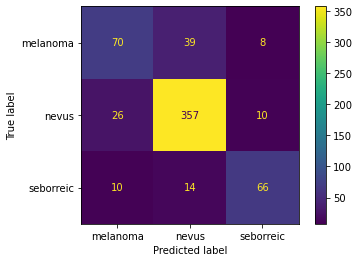

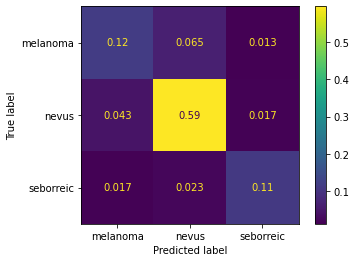

In [23]:
disp1 = ConfusionMatrixDisplay(cm, display_labels=['melanoma','nevus','seborreic'])
disp2 = ConfusionMatrixDisplay(cm_decimal, display_labels=['melanoma','nevus','seborreic'])
disp1.plot()
disp2.plot()
plt.show()

In [25]:
roc_auc_score(targs.cpu().numpy(), preds.softmax(-1).cpu().numpy(), 
                              average='weighted', multi_class='ovo')


0.9282849818403254